# EWAS Runs v2

Epigenome-wide association studies (EWAS) are similar to GWAS, but instead of looking at genetic variation, they look at epigenetic variation.

## Where the data at?

In [37]:
import pandas as pd
import sys
sys.path.append('../')

mount = '/mnt/e/ALMA/'
input_path = mount + 'Intermediate_Files/'
output_path = mount + 'Processed_Files/'
zhou2016_probes_path =  mount + 'UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

## Load data

In [3]:
# read df_discovery and df_test
df_methyl = pd.read_pickle(
    input_path+'3314samples_331557cpgs_nobatchcorrection_bvalues.pkl').sort_index()

# Read clinical data
df_labels = pd.read_excel(input_path+'clinical_data.xlsx', index_col=0)

## Remove samples based on certain clinical features

### Select samples from AAML1031, 0531, and 03P1 clinical trials

In [4]:
df1 = df_labels[df_labels['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]

print(
    f'{df_labels.shape[0]-df1.shape[0]} samples were removed. {df1.shape[0]} samples remaining.')


2228 samples were removed. 1287 samples remaining.


### Select diagnostic samples only

In [5]:
df2 = df1[df1['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow', 'Primary Blood Derived Cancer - Peripheral Blood'])]

print(
    f'{df1.shape[0]-df2.shape[0]} samples were removed. {df2.shape[0]} samples remaining.')

332 samples were removed. 955 samples remaining.


### Remove duplicate samples

In [6]:
df3 = df2[~df2['Patient_ID'].duplicated(keep='last')]

print(
    f'{df2.shape[0]-df3.shape[0]} samples were removed. {df3.shape[0]} samples remaining.')


9 samples were removed. 946 samples remaining.


### Match samples in clinical data to samples in methylation data

In [7]:
# Match samples in clinical data to samples in methylation data
df_methyl_filtered = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 1:]

print('Samples in clinical data matched to samples in methylation data.')

Samples in clinical data matched to samples in methylation data.


## Transform to M-values

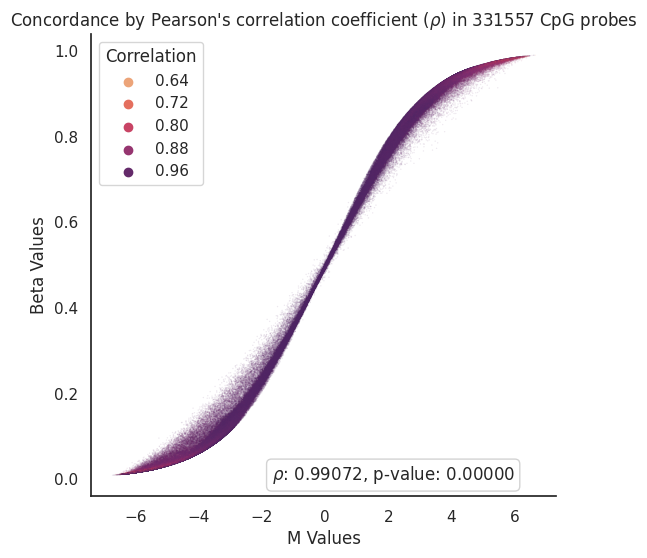

In [8]:
import math
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt


def beta2m(val):
    '''Transfrom beta-values into m-values'''
    return math.log2(val/(1-val))

x_train_m = df_methyl_filtered.apply(np.vectorize(beta2m))

# Get correlation between Beta and M Values
corr = x_train_m.corrwith(df_methyl_filtered, axis=0)

# Glue them into same dataframe for vizualization purposes
beta_to_m_values = pd.concat([x_train_m.mean(),df_methyl_filtered.mean(),corr],axis=1,
                             keys=['M Values','Beta Values','Correlation'],
                             join= 'inner')

def draw_scatterplot(df,x,y,hue,s):
    
    # Define theme

    sns.set_theme(style="white")
    f, ax = plt.subplots(figsize=(6, 6))
    sns.despine(f, left=False, bottom=False)

    # Define scatterplot

    sns.scatterplot(x=x, y=y,
                    hue=hue, palette='flare', s=s,
                    sizes=(1, 8), linewidth=0, alpha=0.1,
                    data=df, ax=ax)

    # Calculate Pearson’s correlation coefficient (r)
    # and its two-tailed p-value (p)

    r,p = stats.pearsonr(df[x],df[y])

    # Annotate r and p into the plot

    plt.annotate(fr'$\rho$: {r:.5f}, p-value: {p:.5f}',
                xy=(6.0, 0.01), xycoords='data',
                ha='right', va='center',
                bbox={'boxstyle': 'round', 'facecolor': 'none',
                'edgecolor': 'lightgray'})

    # Define plot specs

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(r"Concordance by Pearson's correlation coefficient ($\rho$) in " + str(len(df)) + ' CpG probes',
               fontsize = 12) 

    # Save plot figure
    
    # plt.savefig('../Figures/Beta_to_M_Values_' + str(len(df)) + '_scatterplot' + '.png',
    #              bbox_inches='tight', dpi=300)

    return(plt.show())

draw_scatterplot(df=beta_to_m_values,x='M Values',y='Beta Values',hue='Correlation',s=1)

## Perform batch correction

- __pyCombat__ is a Python tool for batch effects correction in high-throughput molecular data using empirical Bayes methods

- __Github__: [https://epigenelabs.github.io/pyComBat/](https://epigenelabs.github.io/pyComBat/)

- __Implementation Preprint__: [bioRxiv](https://doi.org/10.1101/2020.03.17.995431)

- __Original Paper__: [Adjusting batch effects in microarray expression data using empirical Bayes methods](https://pubmed.ncbi.nlm.nih.gov/16632515/)

In [9]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_batchcorrected = pycombat(data = x_train_m.T, batch = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]).round(3).T

print('Succesfully corrected batch effects in the training dataset.')


Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

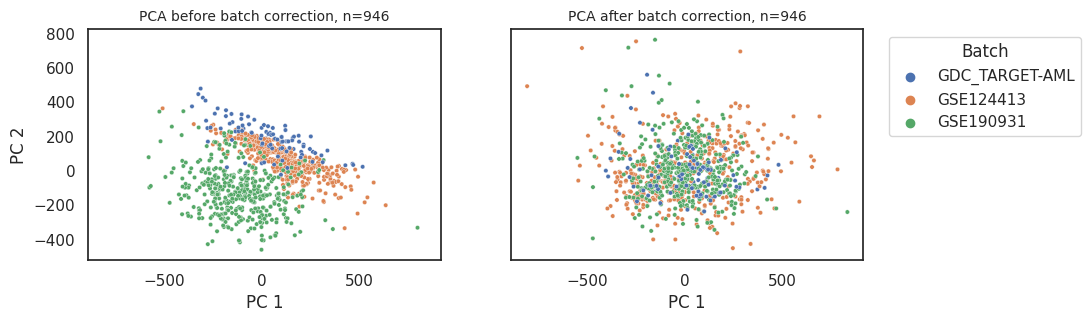

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df_methyl[df_methyl.index.isin(df3.index)].iloc[:, 0]
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

X_std = standardize_data(df_batchcorrected.T)
principal_components = perform_pca(X_std)
pcs_batchcorrected = create_principal_df(principal_components, df_batchcorrected.T)

X_std = standardize_data(x_train_m.T)
principal_components = perform_pca(X_std)
pcs_uncorrected = create_principal_df(principal_components, x_train_m.T)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(pcs_batchcorrected, pcs_uncorrected)


```{note}
1. GDC_TARGET-AML contains AAML0531 and 03P1 samples from methylation array 450k.
2. GSE124413 contains AAML0531 and 03P1 samples from methylation array EPIC.
3. GSE190931 contains AAML1031 samples from methylation array EPIC.
```

### Save dataframe for other analyses

In [11]:
# Save file as csv
# df_batchcorrected.to_csv(output_path+'methylation_dataset_m-values_COG-940-dx-pts_batch-corrected_FMarchi-1-19-24.csv')

# Save file as .RData
# import pyreadr

# pyreadr.write_rdata(output_path+'methylation_dataset_m-values_COG-940-dx-pts_batch-corrected_FMarchi-1-19-24.RData',
#                     df_batchcorrected.reset_index())

## Run CoxPH-EWAS

### Import custom functions adapted from `methylize`

In [12]:
from source.methylize_custom_code.diff_meth_pos_custom import *

In [18]:
# new_risk = pd.read_csv(input_path + 'updated_risk_group_COG_RR_1-10-2024/COG_risk_added_v2_cleanedFM.csv',
#                        index_col=0,)
                       
# df4 = df3.join(new_risk[['Cyto/Molecular Risk']])

# import seaborn as sns
# sns.set_theme(style="white")

def impute_by_mean(df):
    '''Impute missing values by computing feature average'''
    return df.fillna(df.mean())

### Overall survival - updated RR risk group

In [20]:
df4 = df3.assign(Risk_Group_Bin=df3['Risk Group AAML1831'].map({'Low':0, 'Standard':0.5,'High':1}))

# Change df4['Vital Status'] to binary
df4['Vital Status at 5y'] = df4['Vital Status at 5y'].map({'Alive':0, 'Dead':1})

Probes:   0%|          | 0/331557 [00:00<?, ?it/s]

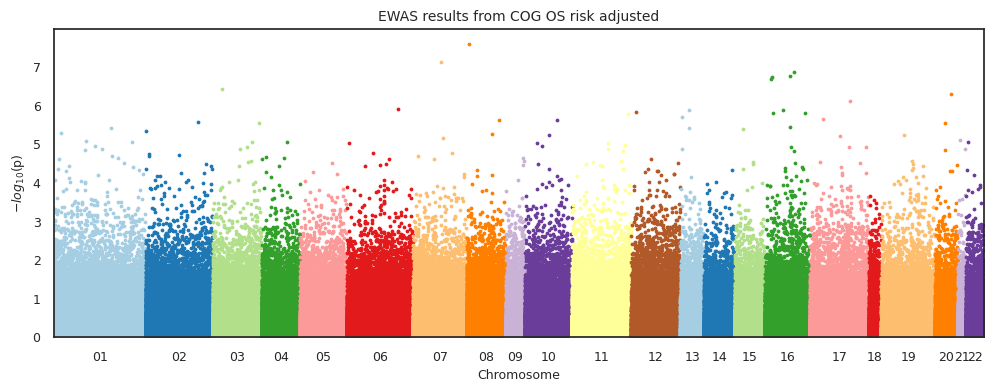

In [32]:

# covar_os = round(impute_by_mean(df4[['Vital Status at 5y','os.time at 5y','Risk_Group_Bin']]),3)

# ewas_os_cog_adjusted = diff_meth_pos(meth_data = df_batchcorrected,
#                                     duration = covar_os['os.time at 5y'],
#                                     event_observed = covar_os['Vital Status at 5y'],
#                                     pheno_data = covar_os['os.time at 5y'], # not used
#                                     covariates = covar_os['Risk_Group_Bin'],
#                                     regression_method = "coxph",
#                                     export = 'pkl',
#                                     verbose = False,
#                                     filename=output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_adjusted')

ewas_os_cog_adjusted = pd.read_pickle(output_path + 'ewas_dmr/ewas_cog_os_batch_corrected_risk_adjusted.pkl')

manhattan_plot(stats_results=ewas_os_cog_adjusted,
                        palette='Paired',
                        save=False,
                        suggestive=True,
                        significant= False,
                        width=12,
                        height=4,
                        statsmode=False,
                        bonferroni=False,
                        fontsize=9,
                        array_type='450k',
                        explore=False,
                        border = True,
                        label_sig_probes=False,
                        fwer=0.05,
                        cohorts= " COG OS risk adjusted",
                        filename='../Figures/Manhattan_Plots/ewas_os_unadjusted')

## Select statistically significant CpGs

### Threshold based on suggested-significance p-values (1*10e-5)

In [34]:
# Select only rows where `PValue`< 1*10e-5
ewas_os_cog_adjusted_sig = ewas_os_cog_adjusted[ewas_os_cog_adjusted['PValue'] < 1*10e-5]

#### Fetch genes

In [48]:
# Define a function to handle repetitive tasks
def process_df(df, other_df, column_drop):
    # Join and sort values
    df = df.join(other_df.drop(columns=column_drop), how='inner').sort_values(by='PValue')

    # Handle columns with multiple genes separated by `;`
    for col in ['GeneNames', 'GeneClasses']:
        df[col] = df[col].apply(lambda x: ';'.join(set(x.split(';'))))

    return df

# Load manifest
zhou2016_probes = pd.read_csv(zhou2016_probes_path,
                              sep='\t',index_col=0)[['chrm','start', 'end', 'GeneNames',
                                                     'GeneClasses','CGIPosition']]

# Get probes from Zhou et al. (2016) that are in ewasOS_un.index
top_os = process_df(zhou2016_probes, ewas_os_cog_adjusted_sig, ['chromosome', 'MAPINFO'])

# Now include the date in the filename and save to excel
import datetime
top_os.to_excel(output_path + 'ewas_dmr/ewas_stats_' + str(datetime.date.today()) + '.xlsx')

## Save top probes

In [78]:
# Select only significant probes
ewas_top_cpgs_os = df_batchcorrected[top_os.index.to_list()]

# Save x to pickle in output_path
ewas_top_cpgs_os.to_csv(output_path + 'ewas_dmr/ewas_top_cpgs_os'+ str(datetime.date.today())+ '.csv')

## Standardize for Lasso

In [82]:
def standardize_data(df, reference_df):
    """Standardize data using mean and standard deviation of reference dataset"""

    # Keep only columns that are in both datasets
    reference_df = reference_df.loc[:, df.columns]

    # Standardize data
    df = (df - reference_df.mean()) / reference_df.std()

    return df

# Standardize data
x_test_m_z = standardize_data(df= ewas_top_cpgs_os, reference_df= ewas_top_cpgs_os)

# Save standardized data
# x_test_m_z.to_excel('../data/ewas_top_167_cpgs_M-Values_standardized_discovery_cohort.xlsx')

In [84]:
import sys
sys.path.append('../')
from source.cox_lasso import *

raw_coefs = train_coxph_lasso(df=df4.copy(),
                                event= 'Vital Status at 5y',
                                time= 'os.time at 5y',
                                train_x=x_test_m_z,
                                cv_n_split=10,
                                loops=1000)
raw_coefs.to_csv(output_path + 'ewas_dmr/ewas_cog_os_raw_coefs_newrisk.csv')


raw_coefs = pd.read_csv(output_path + 'ewas_dmr/ewas_cog_os_raw_coefs_newrisk.csv', index_col=0)

Running Cox-Lasso through 1000 loops:


  0%|          | 0/1000 [00:00<?, ?it/s]/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
  0%|          | 1/1000 [00:08<2:25:57,  8.77s/it]/home/fmarchi/projects/MethylScore/Code/.venv_py38/lib/python3.8/site-packages/sklearn/pipeline.py:405: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_l

Cox-Lasso Trained Successfuly!
Selected alpha value: [0.016267686397758482]


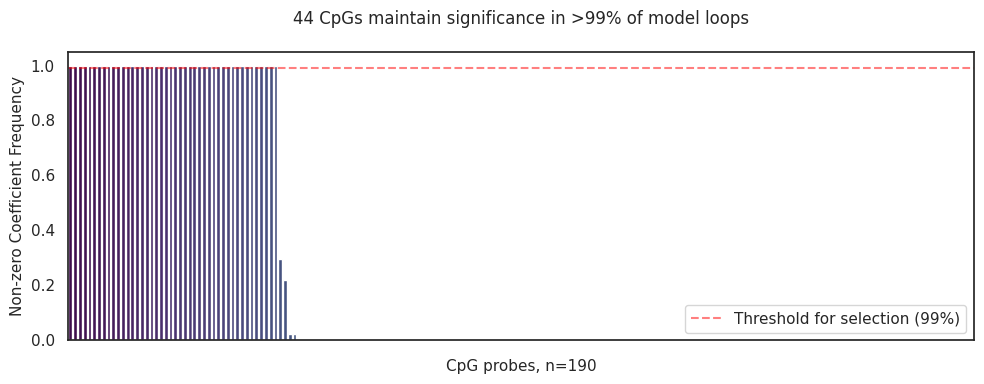

In [85]:
mean_coefs = set_cutoff(coefs=raw_coefs,threshold=0.99)
                                
plot_nonzero_coef_freq(raw_coefs, mean_coefs, threshold=0.99, savefig=False, fig_path=None, figsize=(10,4))

In [86]:
score_name = 'MethylScoreAML'

df5, threshold = generate_coxph_score(coef_mean=mean_coefs,
                                        x=ewas_top_cpgs_os,
                                        df=df4,
                                        score_name=score_name,
                                        train_test="train",
                                        rpart_outcome='os.time at 5y',)

# df.to_excel(output_path + 'multivariate_cox_lasso/ewas_cog_os_MethylScoreAML_Px.xlsx')

Continuous score cut at the value of -2.251


Text(0.5, 1.0, 'Distribution of MethylScoreAML in COG trials')

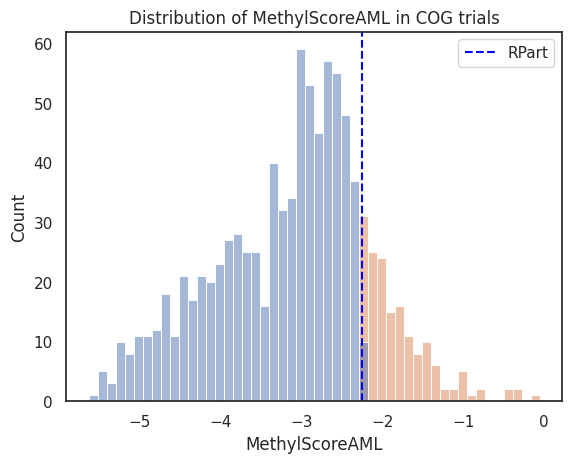

In [87]:
sns.histplot(data=df5,x=score_name, bins=50, hue = score_name + ' Categorical' )

# add vertical line at threshold and third quartile
plt.axvline(threshold ,color='blue', linestyle='--')


# add legend
plt.legend({'RPart':threshold})
plt.title('Distribution of ' + score_name + ' in COG trials')

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

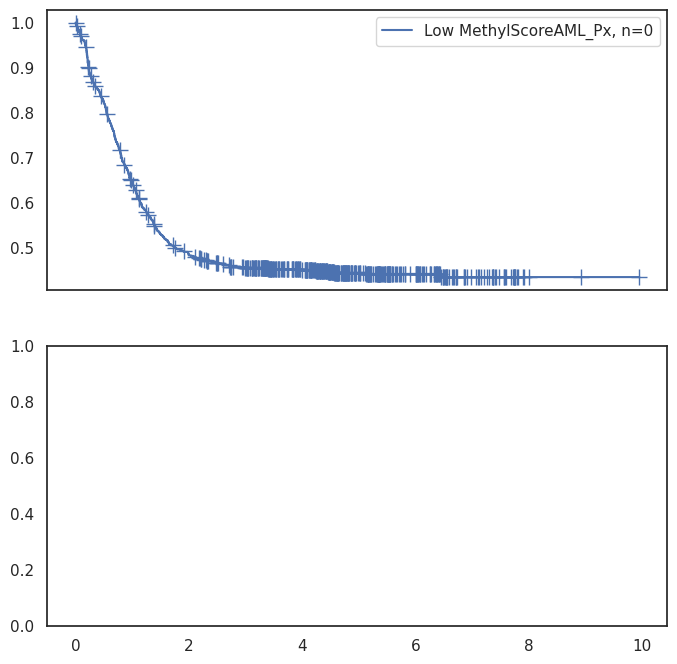

In [69]:
import sys
sys.path.append('../')
from source.data_visualization import *

draw_kaplan_meier(model_name=score_name,
                        df=df5,
                        save_survival_table=False,
                        save_plot=False,
                        show_ci=False,
                        add_risk_counts=False,
                        trialname='COG',
                        figsize=(8,8))

## Watermark

In [23]:
%load_ext watermark

In [24]:
%watermark -v -p methylize,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

methylize: 1.1.1
pandas   : 2.0.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

